In [1]:
import pathlib
import numpy as np
import skimage
import plotly.graph_objects as go

from scipy.spatial import ConvexHull

import matplotlib.pyplot as plt
from matplotlib.path import Path as pltpath
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import matplotlib.cm as mcm


import open3d as o3d
from copy import deepcopy

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
from pin_segment import RgbdPinFetcher, SfMPinFetcher

In [3]:
dataset_root = pathlib.Path(r'/home/crest/w/hwang_Pro/datasets/3DPotatoTwin')
pin_ref_folder = pathlib.Path(r'/home/crest/Documents/Github/PotatoScan/3dscan/03_sfm_rgbd_registration/pin_ref')

In [4]:
rgbd_fetcher = RgbdPinFetcher(dataset_root)
sfm_fetcher = SfMPinFetcher(dataset_root, pin_ref_folder)

loading annotations into memory...
Done (t=0.19s)
creating index...
index created!


In [5]:
potato_id = 'R3-3'

rgbd_data = rgbd_fetcher.get(potato_id, show=True)
sfm_data = sfm_fetcher.get(potato_id, visualize=True)

Thresh=0.35 get pin convex hull volumn 96018.77215018909 > 60, denoise first
Thresh=0.3 get pin convex hull volumn 92337.85037083643 > 60, denoise first
Thresh=0.25 get pin convex hull volumn 66611.87525249115 > 60, denoise first
Thresh=0.2 get pin convex hull volumn 3900.371686427296 > 60, denoise first
Stop at thresh=0.2 with hull volume = 57.303338228588636 after denoising


In [6]:
from pin_center import find_pin_center

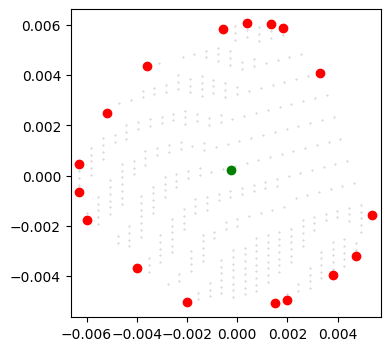

In [7]:
sfm_pin_data = find_pin_center(sfm_data['pin_pcd'], circle_color=[0,0,0], show=True)
rgbd_pin_data = find_pin_center(rgbd_data['pin_pcd'], circle_color=[0,0,0],visualize=True)

Visualize for preprocessing rsults (frame 1)

In [8]:
sfm_data.keys()

dict_keys(['pin_idx', 'pcd', 'pcd_offset_colormap', 'pin_pcd_strengthen', 'pin_pcd'])

In [9]:
rgbd_data.keys()

dict_keys(['pcd', 'pin_pcd', 'pin_idx'])

In [10]:
rgbd_pin_data.keys()

dict_keys(['circle_center_3d', 'circle_radius', 'vector', 'projected_cloud', 'circle_mesh', 'vector_lineset'])

In [11]:
o3d.visualization.draw_geometries([
    #sfm & rgbd raw data
    sfm_data['pcd'], rgbd_data['pcd'],
    # pin segmetation result (with color strength)
    sfm_data['pin_pcd_strengthen'], rgbd_data['pin_pcd'],
    # sfm hsv intermediate visualization
    sfm_data['pcd_offset_colormap'],
    # regressed circle
    sfm_pin_data['circle_mesh'], rgbd_pin_data['circle_mesh'],
    # circle plane normal
    sfm_pin_data['vector_lineset'], rgbd_pin_data['vector_lineset'], 
])